#**NOTE: Code adapted from "Towards Interpretable Sequence Continuation: Analyzing Shared Circuits in Large Language Models"** (Mary Phuong and Christoph Lampert. Towards understanding knowledge distillation. In International conference on machine learning, pages 5142–5151. PMLR, 2019.)



In [ ]:
task = "numerals"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 128 #768 512

model_name = "distillgpt2"

save_files = True

# Setup

In [ ]:
!rm -rf /content/*

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle

In [ ]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-x2yo5twv
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-x2yo5twv
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit e65fafb4791c66076bc54ec9731920de1e8c676f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.4 MB/s eta 0:00:00
   

In [ ]:
from transformer_lens import HookedTransformer
import torch
torch.set_grad_enabled(False)  # turn automatic differentiation off

In [ ]:
!git clone https://github.com/wlg1/seqcont_circ_expms.git

Cloning into 'seqcont_circ_expms'...
remote: Enumerating objects: 875, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 875 (delta 180), reused 208 (delta 131), pack-reused 611 (from 1)
Receiving objects: 100% (875/875), 19.38 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (553/553), done.


In [ ]:
%cd seqcont_circ_expms/src/attn_pats

/content/seqcont_circ_expms/src/attn_pats


In [ ]:
from viz_attn_pat import *

## Load model & Dataset

In [ ]:
model = HookedTransformer.from_pretrained(
    "distillgpt2",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model distillgpt2 into HookedTransformer


In [ ]:


prompts_list = []

for i in prompt_types:
    file_name = f'/content/seqcont_circ_expms/data/{task}/{task}_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    prompts_list += filelist [:num_samps_per_ptype] #768 512 256 128

prompts = [prompt['text'] for prompt in prompts_list]

Van done in 1. Hat done in 2. Ring done in 3. Desk done in 4. Sun done in
Oil lost in 1. Apple lost in 2. Tree lost in 3. Snow lost in 4. Apple lost in
Marcus born in 1. Victoria born in 2. George born in 3. Brandon born in 4. Jamie born in


In [ ]:
tokens = model.to_tokens(prompts, prepend_bos=True)
original_logits, local_cache = model.run_with_cache(tokens) # run the model and cache all activations

# Functions

In [ ]:
token1 = " 3"
token2 = " 2"

local_tokens = tokens[0]
token_list = model.to_str_tokens(local_tokens)

In [ ]:
def get_attn_val(token_list, token1, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = token_list.index(token1)
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:

        patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The avg heatmap value at "{token1}" "{token2}" is {heatmap_value} for {layer}.{head_index}')

get_attn_val(token_list, token1, token2, 4, 4)

The avg heatmap value at " 3" " 2" is 0.007056146860122681 for 4.4


In [ ]:
def get_attn_val_fromEnd(token_list, token2, layer, head_index):
    # Find the indices of the tokens in the tokenized sentence
    try:
        query_ind = -1
        key_ind = token_list.index(token2)
    except ValueError as e:
        print(f"Token not found: {e}")
    else:

        patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
        heatmap_value = patterns[query_ind, key_ind]
        print(f'The avg heatmap value at last token to "{token2}" is {heatmap_value} for {layer}.{head_index}')

get_attn_val_fromEnd(token_list, token1, 5, 1)
get_attn_val_fromEnd(token_list, token2, 5, 1)

The avg heatmap value at last token to " 3" is 0.013858770951628685 for 5.1
The avg heatmap value at last token to " 2" is 0.01690497063100338 for 5.1


In [ ]:
get_ind(token_list, " 3", " 2", printInd=True)

The index of ' 3' is 14
The index of ' 2' is 9


(14, 9)

# Edge Pruning

## Setup

In [ ]:
task = "numerals"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 512 #768 512

model_name = "distillgpt2"

# ablation is performed by patching
# in the mean activations of a corrupted dataset at
# N \ C, which are the nodes that are not part of
# of the current candidate circuit. Then, the mean
# activations of the corrupted dataset are also patched
# in at new candidate node nc. If performance falls
# below Tn, a user-defined performance threshold,
# node nc is kept in the candidate circuit C, as it is
# deemed necessary for the task. Else, it is removed.

# choose heads and MLPs that are suspected to play an important role.
# do not ablate these, as we want to measure the effect of ablation of the rest
# of the network on these components (determined by node pruning section)
heads_not_ablate = [(0, 1), (2, 4), (3, 7), (3, 10), (3, 11), (4, 1), (4, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5]

threshold = 0.8
save_files = True
load_graph_files = False
run_on_other_tasks = True

In [ ]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [ ]:
import torch as t
from torch import Tensor
from jaxtyping import Float
from typing import List, Optional, Callable, Tuple
from functools import partial

import pickle
from google.colab import files

from graphviz import Digraph, Source
from IPython.display import display

In [ ]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)
from transformer_lens import HookedTransformer, ActivationCache

t.set_grad_enabled(False)

In [ ]:
model = HookedTransformer.from_pretrained(
    model_name,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model distillgpt2 into HookedTransformer


In [ ]:
%cd ../../../../../../../content
!git clone https://github.com/apartresearch/seqcont_circuits.git

/content
Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 1098, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 1098 (delta 30), reused 21 (delta 21), pack-reused 1057 (from 1)
Receiving objects: 100% (1098/1098), 20.04 MiB | 8.93 MiB/s, done.
Resolving deltas: 100% (739/739), done.


In [ ]:

%cd seqcont_circuits/src/iter_edge_pruning
from dataset import Dataset
from metrics import *
%cd ../iter_node_pruning
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

/content/seqcont_circuits/src/iter_edge_pruning
/content/seqcont_circuits/src/iter_node_pruning


In [ ]:
%cd ../iter_edge_pruning

from edge_pruning_fns import *
from viz_circuits import *

/content/seqcont_circuits/src/iter_edge_pruning


In [ ]:
%cd ../../../../../../../content

/content


In [ ]:
prompts_list = []

for i in prompt_types:
    file_name = f'/content/seqcont_circuits/data/{task}/{task}_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    prompts_list += filelist [:num_samps_per_ptype]

len(prompts_list)

Van done in 1. Hat done in 2. Ring done in 3. Desk done in 4. Sun done in
Oil lost in 1. Apple lost in 2. Tree lost in 3. Snow lost in 4. Apple lost in
Marcus born in 1. Victoria born in 2. George born in 3. Brandon born in 4. Jamie born in


1536

In [ ]:
pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i
dataset_1 = Dataset(prompts_list, pos_dict, model.tokenizer)

file_name = f'/content/seqcont_circuits/data/{task}/randDS_{task}.pkl'
with open(file_name, 'rb') as file:
    prompts_list_2 = pickle.load(file)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)

In [ ]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset_1.toks)
orig_score = get_logit_diff(logits_original, dataset_1)

In [ ]:
def logit_diff_perc(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float = orig_score,
    dataset_1: Dataset = dataset_1,
) -> float:
    patched_logit_diff = get_logit_diff(logits, dataset_1)
    return (patched_logit_diff / clean_logit_diff)

In [ ]:
import gc

del(logits_original)
# del(logits_corrup)
t.cuda.empty_cache()
gc.collect()

289

## Find Circuit

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
abl_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset_1.toks)
new_score = get_logit_diff(new_logits, dataset_1)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")
del(new_logits)

(cand circuit / full) %: 80.1223


### Head to head

In [ ]:
qkv_to_HH = {} # qkv to dict

for head_type in ["q", "k", "v"]:
    head_to_head_results = {}
    for head in heads_not_ablate:
        print(head_type, head)
        model.reset_hooks()
        model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

        result = circ_path_patch_head_to_heads(
            circuit = heads_not_ablate,
            receiver_heads = [head],
            receiver_input = head_type,
            model = model,
            patching_metric = logit_diff_perc,
            new_dataset = dataset_2,
            orig_dataset = dataset_1
        )
        head_to_head_results[head] = result
    qkv_to_HH[head_type] = head_to_head_results

q (0, 1)
q (2, 4)
q (3, 7)
q (3, 10)
q (3, 11)
q (4, 1)
q (4, 7)
k (0, 1)
k (2, 4)
k (3, 7)
k (3, 10)
k (3, 11)
k (4, 1)
k (4, 7)
v (0, 1)
v (2, 4)
v (3, 7)
v (3, 10)
v (3, 11)
v (4, 1)
v (4, 7)


In [ ]:
head_to_head_adjList = {}
for head_type in ["q", "k", "v"]:
    for head in heads_not_ablate:
        result = qkv_to_HH[head_type][head]
        filtered_indices = (result < threshold) & (result != 0.0)
        rows, cols = filtered_indices.nonzero(as_tuple=True)
        sender_nodes = list(zip(rows.tolist(), cols.tolist()))
        head_with_type = head + (head_type,)
        head_to_head_adjList[head_with_type] = sender_nodes

### MLP to MLP

In [ ]:
mlp_to_mlp_results = {}

for layer in reversed(mlps_not_ablate):
    print(layer)
    model.reset_hooks()
    model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
    result = circ_path_patch_MLPs_to_MLPs(
        mlp_circuit = mlps_not_ablate,
        receiver_layers = [layer],
        model = model,
        patching_metric = logit_diff_perc,
        new_dataset = dataset_2,
        orig_dataset = dataset_1
    )
    mlp_to_mlp_results[layer] = result

5
4
3
2
1
0


In [ ]:
mlp_to_mlp_adjList = {}
for mlp in mlps_not_ablate:
    result = mlp_to_mlp_results[mlp]
    filtered_indices = (result < threshold) & (result != 0.0)
    filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
    mlp_to_mlp_adjList[mlp] = filtered_indices.tolist()

### Head to MLP

In [ ]:
head_to_mlp_results = {}

for layer in reversed(mlps_not_ablate):
    print(layer)
    model.reset_hooks()
    model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)
    result = circ_path_patch_head_to_mlp(
        circuit = heads_not_ablate,
        receiver_layers = [layer],
        model = model,
        patching_metric = logit_diff_perc,
        new_dataset = dataset_2,
        orig_dataset = dataset_1
    )
    head_to_mlp_results[layer] = result

5
4
3
2
1
0


In [ ]:
head_to_mlp_adjList = {}
for layer in mlps_not_ablate:
    result = head_to_mlp_results[layer]
    filtered_indices = (result < threshold) & (result != 0.0)
    rows, cols = filtered_indices.nonzero(as_tuple=True)
    sender_nodes = list(zip(rows.tolist(), cols.tolist()))
    head_to_mlp_adjList[layer] = sender_nodes

### MLP to head

In [ ]:
qkv_mlp_to_HH = {} # qkv to dict

for head_type in ["q", "k", "v"]:
    mlp_to_head_results = {}
    for head in heads_not_ablate:
        print(head_type, head)
        model.reset_hooks()
        model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

        result = circ_path_patch_mlp_to_head(
            mlp_circuit = mlps_not_ablate,
            receiver_heads = [head],
            receiver_input = head_type,
            model = model,
            patching_metric = logit_diff_perc,
            new_dataset = dataset_2,
            orig_dataset = dataset_1
        )
        mlp_to_head_results[head] = result
    qkv_mlp_to_HH[head_type] = mlp_to_head_results

q (0, 1)
q (2, 4)
q (3, 7)
q (3, 10)
q (3, 11)
q (4, 1)
q (4, 7)
k (0, 1)
k (2, 4)
k (3, 7)
k (3, 10)
k (3, 11)
k (4, 1)
k (4, 7)
v (0, 1)
v (2, 4)
v (3, 7)
v (3, 10)
v (3, 11)
v (4, 1)
v (4, 7)


In [ ]:
mlp_to_head_adjList = {}
for head_type in ["q", "k", "v"]:
    for head in heads_not_ablate:
        result = qkv_mlp_to_HH[head_type][head]
        filtered_indices = (result < threshold) & (result != 0.0)
        filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
        head_with_type = head + (head_type,)
        mlp_to_head_adjList[head_with_type] = filtered_indices.tolist()

### Save graph files

In [ ]:
if save_files:
    with open(task + "_head_to_head_results.pkl", "wb") as file:
        pickle.dump(head_to_head_results, file)
    files.download(task + "_head_to_head_results.pkl")

    with open(task + "_mlp_to_mlp_results.pkl", "wb") as file:
        pickle.dump(mlp_to_mlp_results, file)
    files.download(task + "_mlp_to_mlp_results.pkl")

    with open(task + "_head_to_mlp_results.pkl", "wb") as file:
        pickle.dump(head_to_mlp_results, file)
    files.download(task + "_head_to_mlp_results.pkl")

    with open(task + "_mlp_to_head_results.pkl", "wb") as file:
        pickle.dump(mlp_to_head_results, file)
    files.download(task + "_mlp_to_head_results.pkl")

del(head_to_head_results)
del(mlp_to_mlp_results)
del(head_to_mlp_results)
del(mlp_to_head_results)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run iterative edge pruning - residual post

### Head to resid

In [ ]:
model.reset_hooks()
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

path_patch_head_to_final_resid_post = get_path_patch_head_to_final_resid_post(heads_not_ablate, model, logit_diff_perc,
                                                                new_dataset = dataset_2, orig_dataset = dataset_1)

In [ ]:
heads_to_resid = {}
result = path_patch_head_to_final_resid_post
filtered_indices = (result < threshold) & (result != 0.0)
rows, cols = filtered_indices.nonzero(as_tuple=True)
heads_to_resid['resid'] = list(zip(rows.tolist(), cols.tolist()))

### MLP to resid

In [ ]:
model.reset_hooks()
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

path_patch_mlp_to_final_resid_post = get_path_patch_mlp_to_final_resid_post(mlps_not_ablate, model, logit_diff_perc,
                                                                new_dataset = dataset_2, orig_dataset = dataset_1)

In [ ]:
mlps_to_resid = {}
result = path_patch_mlp_to_final_resid_post
filtered_indices = (result < threshold) & (result != 0.0)
filtered_indices = filtered_indices.nonzero(as_tuple=True)[0]
mlps_to_resid['resid'] = filtered_indices.tolist()

### Filter out nodes with no ingoing edges

In [ ]:
head_to_head_adjList = {node: neighbors for node, neighbors in head_to_head_adjList.items() if neighbors}

In [ ]:
mlp_to_head_adjList = {node: neighbors for node, neighbors in mlp_to_head_adjList.items() if neighbors}

### Save graph files

In [ ]:
if save_files:
    # graphs
    with open(task + "_head_to_head_adjList.pkl", "wb") as file:
        pickle.dump(head_to_head_adjList, file)
    files.download(task + "_head_to_head_adjList.pkl")

    with open(task + "_mlp_to_mlp_adjList.pkl", "wb") as file:
        pickle.dump(mlp_to_mlp_adjList, file)
    files.download(task + "_mlp_to_mlp_adjList.pkl")

    with open(task + "_head_to_mlp_adjList.pkl", "wb") as file:
        pickle.dump(head_to_mlp_adjList, file)
    files.download(task + "_head_to_mlp_adjList.pkl")

    with open(task + "_mlp_to_head_adjList.pkl", "wb") as file:
        pickle.dump(mlp_to_head_adjList, file)
    files.download(task + "_mlp_to_head_adjList.pkl")

    with open(task + "_heads_to_resid.pkl", "wb") as file:
        pickle.dump(heads_to_resid, file)
    files.download(task + "_heads_to_resid.pkl")

    with open(task + "_mlps_to_resid.pkl", "wb") as file:
        pickle.dump(mlps_to_resid, file)
    files.download(task + "_mlps_to_resid.pkl")

    # score results
    with open(task + "_heads_to_resid_results.pkl", "wb") as file:
        pickle.dump(path_patch_head_to_final_resid_post, file)
    files.download(task + "_heads_to_resid_results.pkl")

    with open(task + "_mlps_to_resid_results.pkl", "wb") as file:
        pickle.dump(path_patch_mlp_to_final_resid_post, file)
    files.download(task + "_mlps_to_resid_results.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Circuit graph plot

### Load data

In [ ]:
if load_graph_files:
    with open(task + "_head_to_head_adjList.pkl", "rb") as file:
        head_to_head_adjList = pickle.load(file)

    with open(task + "_mlp_to_mlp_adjList.pkl", "rb") as file:
        mlp_to_mlp_adjList = pickle.load(file)

    with open(task + "_head_to_mlp_adjList.pkl", "rb") as file:
        head_to_mlp_adjList = pickle.load(file)

    with open(task + "_mlp_to_head_adjList.pkl", "rb") as file:
        mlp_to_head_adjList = pickle.load(file)

    with open(task + "_heads_to_resid.pkl", "rb") as file:
        heads_to_resid = pickle.load(file)

    with open(task + "_mlps_to_resid.pkl", "rb") as file:
        mlps_to_resid = pickle.load(file)

### Plot QKV

In [ ]:
plot_graph_adjacency_qkv(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList,
                         mlp_to_head_adjList, heads_to_resid, mlps_to_resid, filename="qkv")

### Plot no QKV filename

In [ ]:
plot_graph_adjacency(head_to_head_adjList, mlp_to_mlp_adjList, head_to_mlp_adjList,
                         mlp_to_head_adjList, heads_to_resid, mlps_to_resid, filename="no qkv")

In [ ]:
!zip -r /content/seqcont_circ_expms_zip_edge.zip /content/seqcont_circ_expms
!zip -r /content/seqcont_circuits_zip_edge.zip /content/seqcont_circuits

  adding: content/seqcont_circ_expms/ (stored 0%)
  adding: content/seqcont_circ_expms/LICENSE (deflated 41%)
  adding: content/seqcont_circ_expms/other_nbs_explora/ (stored 0%)
  adding: content/seqcont_circ_expms/other_nbs_explora/gpt2_seqContCircs_explora/ (stored 0%)
  adding: content/seqcont_circ_expms/other_nbs_explora/gpt2_seqContCircs_explora/ablate_attnLayer_thenHeads/ (stored 0%)
  adding: content/seqcont_circ_expms/other_nbs_explora/gpt2_seqContCircs_explora/ablate_attnLayer_thenHeads/ablate_attnLayer_thenHeads_GPT2.ipynb (deflated 86%)
  adding: content/seqcont_circ_expms/other_nbs_explora/gpt2_seqContCircs_explora/test_ablate_then_modelGen.ipynb (deflated 89%)
  adding: content/seqcont_circ_expms/other_nbs_explora/gpt2_seqContCircs_explora/test_logit_diff_multToks.ipynb (deflated 89%)
  adding: content/seqcont_circ_expms/other_nbs_explora/gpt2_seqContCircs_explora/ablate_seqcont_thenMath_explora_v2.ipynb (deflated 89%)
  adding: content/seqcont_circ_expms/other_nbs_explora

# Node Pruning

In [ ]:
%cd ../../../../../../../../../../../content
%ls

/content
'no qkv'                               numerals_mlp_to_head_adjList.pkl
'no qkv.png'                           numerals_mlp_to_head_results.pkl
 numerals_heads_to_resid.pkl           numerals_mlp_to_mlp_adjList.pkl
 numerals_heads_to_resid_results.pkl   numerals_mlp_to_mlp_results.pkl
 numerals_head_to_head_adjList.pkl     qkv
 numerals_head_to_head_results.pkl     qkv.png
 numerals_head_to_mlp_adjList.pkl      seqcont_circ_expms/
 numerals_head_to_mlp_results.pkl      seqcont_circ_expms_zip_edge.zip
 numerals_mlps_to_resid.pkl            seqcont_circuits/
 numerals_mlps_to_resid_results.pkl    seqcont_circuits_zip_edge.zip


In [ ]:
task = "numerals"  # choose: numerals, numwords, months
prompt_types = ['done', 'lost', 'names']
num_samps_per_ptype = 512 #768 512

model_name = "distillgpt2"

save_files = True
run_on_other_tasks = True

In [ ]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-29lksr11
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-29lksr11
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit e65fafb4791c66076bc54ec9731920de1e8c676f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [ ]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
model = HookedTransformer.from_pretrained(
    model_name,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model distillgpt2 into HookedTransformer


In [ ]:
!git clone https://github.com/apartresearch/seqcont_circuits.git

fatal: destination path 'seqcont_circuits' already exists and is not an empty directory.


In [ ]:
%cd seqcont_circuits/src/iter_node_pruning
from dataset import Dataset
%cd ..
from generate_data import *
%cd iter_node_pruning
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

/content/seqcont_circuits/src/iter_node_pruning
/content/seqcont_circuits/src
/content/seqcont_circuits/src/iter_node_pruning


In [ ]:
prompts_list = []

for i in prompt_types:
    file_name = f'/content/seqcont_circuits/data/{task}/{task}_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    prompts_list += filelist [:num_samps_per_ptype]

len(prompts_list)

Van done in 1. Hat done in 2. Ring done in 3. Desk done in 4. Sun done in
Oil lost in 1. Apple lost in 2. Tree lost in 3. Snow lost in 4. Apple lost in
Marcus born in 1. Victoria born in 2. George born in 3. Brandon born in 4. Jamie born in


1536

In [ ]:
pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i

In [ ]:
dataset = Dataset(prompts_list, pos_dict, model.tokenizer)

In [ ]:
file_name = f'/content/seqcont_circuits/data/{task}/randDS_{task}.pkl'
with open(file_name, 'rb') as file:
    prompts_list_2 = pickle.load(file)

In [ ]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)

## Get Original Score

In [ ]:
model.reset_hooks(including_permanent=True)
logits_original = model(dataset.toks)
orig_score = get_logit_diff(logits_original, dataset)

In [ ]:
import gc

del(logits_original)
torch.cuda.empty_cache()
gc.collect()

4

## Find important attention heads from full

In [ ]:
circ = [(layer, head) for layer in range(6) for head in range(12)] # 6 layers, 12 heads in distilled-gpt2
to_loop = [(layer, head) for layer in range(6) for head in range(12)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 103.1674
removed: (0, 1)
Average logit difference (circuit / full) %: 8.4751
removed: (0, 2)
Average logit difference (circuit / full) %: 88.8917
removed: (0, 3)
Average logit difference (circuit / full) %: 97.2097
removed: (0, 4)
Average logit difference (circuit / full) %: 101.9565
removed: (0, 5)
Average logit difference (circuit / full) %: 87.3976
removed: (0, 6)
Average logit difference (circuit / full) %: 102.9396
removed: (0, 7)
Average logit difference (circuit / full) %: 102.1933
removed: (0, 8)
Average logit difference (circuit / full) %: 100.6175
removed: (0, 9)
Average logit difference (circuit / full) %: 100.5107
removed: (0, 10)
Average logit difference (circuit / full) %: 106.4282
removed: (0, 11)
Average logit difference (circuit / full) %: 100.2653
removed: (1, 0)
Average logit difference (circuit / full) %: 99.6140
removed: (1, 1)
Average logit difference (circuit / full) %: 108.6392
removed: (1, 2)
Average 

In [ ]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
for lh, score in sorted_lh_scores[:10]:
    modified_score = -round(100 - score, 2)
    print(lh, modified_score)

(2, 4) -103.89
(4, 1) -96.25
(0, 1) -91.52
(3, 11) -86.29
(3, 7) -26.89
(3, 2) -15.51
(0, 5) -12.6
(2, 10) -11.98
(4, 11) -11.96
(0, 2) -11.11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

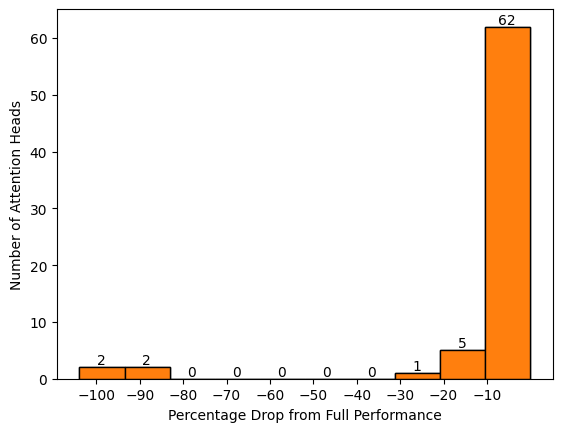

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [ ]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)
if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

Mean of the scores: -7.282671107186212


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Find important MLPs from Full

In [ ]:
for i in range(6):
    lst = [layer for layer in range(6) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 -31.439268112182617
1 19.04349708557129
2 20.387598037719727
3 62.20224380493164
4 -14.147157669067383
5 64.1010971069336


## Node Ablation Iteration

In [ ]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
while prev_score != new_score:
    print('\nbackw prune, iter ', str(iter))
    old_circ_heads = curr_circ_heads.copy() # save old before finding new one
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    print('\nfwd prune, iter ', str(iter))
    # track changes in circuit as for some reason it doesn't work with scores
    old_circ_heads = curr_circ_heads.copy()
    old_circ_mlps = curr_circ_mlps.copy()
    curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
    if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
        break
    all_comp_scores.append(comp_scores)
    iter += 1


backw prune, iter  1
11
(cand circuit / full) %: 100.0000
Removed: MLP  11
11 0
(cand circuit / full) %: 100.0000
Removed: (11, 0)
11 1
(cand circuit / full) %: 100.0000
Removed: (11, 1)
11 2
(cand circuit / full) %: 100.0000
Removed: (11, 2)
11 3
(cand circuit / full) %: 100.0000
Removed: (11, 3)
11 4
(cand circuit / full) %: 100.0000
Removed: (11, 4)
11 5
(cand circuit / full) %: 100.0000
Removed: (11, 5)
11 6
(cand circuit / full) %: 100.0000
Removed: (11, 6)
11 7
(cand circuit / full) %: 100.0000
Removed: (11, 7)
11 8
(cand circuit / full) %: 100.0000
Removed: (11, 8)
11 9
(cand circuit / full) %: 100.0000
Removed: (11, 9)
11 10
(cand circuit / full) %: 100.0000
Removed: (11, 10)
11 11
(cand circuit / full) %: 100.0000
Removed: (11, 11)
10
(cand circuit / full) %: 100.0000
Removed: MLP  10
10 0
(cand circuit / full) %: 100.0000
Removed: (10, 0)
10 1
(cand circuit / full) %: 100.0000
Removed: (10, 1)
10 2
(cand circuit / full) %: 100.0000
Removed: (10, 2)
10 3
(cand circuit / full)

In [ ]:
print(all_comp_scores)
all_comp_scores_filtered = [
    {k: v for k, v in d.items() if (isinstance(k, int) and k <= 5) or (isinstance(k, tuple) and k[0] <= 5)}
    for d in all_comp_scores  # Iterate over the list of dictionaries
]

print(all_comp_scores_filtered)



[{11: tensor(100., device='cuda:0'), (11, 0): tensor(100., device='cuda:0'), (11, 1): tensor(100., device='cuda:0'), (11, 2): tensor(100., device='cuda:0'), (11, 3): tensor(100., device='cuda:0'), (11, 4): tensor(100., device='cuda:0'), (11, 5): tensor(100., device='cuda:0'), (11, 6): tensor(100., device='cuda:0'), (11, 7): tensor(100., device='cuda:0'), (11, 8): tensor(100., device='cuda:0'), (11, 9): tensor(100., device='cuda:0'), (11, 10): tensor(100., device='cuda:0'), (11, 11): tensor(100., device='cuda:0'), 10: tensor(100., device='cuda:0'), (10, 0): tensor(100., device='cuda:0'), (10, 1): tensor(100., device='cuda:0'), (10, 2): tensor(100., device='cuda:0'), (10, 3): tensor(100., device='cuda:0'), (10, 4): tensor(100., device='cuda:0'), (10, 5): tensor(100., device='cuda:0'), (10, 6): tensor(100., device='cuda:0'), (10, 7): tensor(100., device='cuda:0'), (10, 8): tensor(100., device='cuda:0'), (10, 9): tensor(100., device='cuda:0'), (10, 10): tensor(100., device='cuda:0'), (10, 

In [ ]:
all_comp_scores = all_comp_scores_filtered

In [ ]:
with open('numerals_bf_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('numerals_bf_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/seqcont_circuits
from google.colab import files
files.download("/content/seqcont_circuits")


zip error: Nothing to do! (/content/seqcont_circuits.zip)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
curr_circ_heads

[(0, 1), (2, 4), (3, 7), (3, 10), (3, 11), (4, 1), (4, 7)]

In [ ]:
curr_circ_mlps

[0, 1, 2, 3, 4, 5]

## Find most important heads from circuit

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

#81

(cand circuit / full) %: 80.1223


In [ ]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 1)
(cand circuit / full) %: 20.9237
removed: (2, 4)
(cand circuit / full) %: -7.6103
removed: (3, 7)
(cand circuit / full) %: 59.8899
removed: (3, 10)
(cand circuit / full) %: 74.8931
removed: (3, 11)
(cand circuit / full) %: 7.2943
removed: (4, 1)
(cand circuit / full) %: 2.5558
removed: (4, 7)
(cand circuit / full) %: 72.7377


In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

(2, 4) -87.73
(4, 1) -77.57
(3, 11) -72.83
(0, 1) -59.2
(3, 7) -20.23
(4, 7) -7.38
(3, 10) -5.23


# Attention Pattern Analysis

### My stuff:

In [ ]:
def viz_attnPat_dupl(
    layer, head_index,
    highlightLines = True
):
    patterns = local_cache["attn", layer][:, head_index].mean(dim=0)
    patterns_np = patterns.cpu().numpy()

    str_tokens = model.to_str_tokens(tokens[0])
    str_tokens[0] = '<END>'

    mask = np.triu(np.ones_like(patterns_np, dtype=bool), k=1)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        patterns_np,
        xticklabels=str_tokens,
        yticklabels=str_tokens,
        cmap = 'inferno',
        annot=False,
        fmt='.2f',
        linewidths=0.1,
        linecolor='white',
        mask=mask
    )

    ax.set_xlabel('Key', fontsize=16, fontweight='bold')
    ax.set_ylabel('Query', fontsize=16, fontweight='bold')

    if highlightLines:
        import matplotlib.patches as mpatches

        for i in range(0, 19):
            rect = mpatches.Rectangle((i, i), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+5), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            rect = mpatches.Rectangle((i, i+10), 1, 1, linewidth=3.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

    plt.show()


#### L2H4:

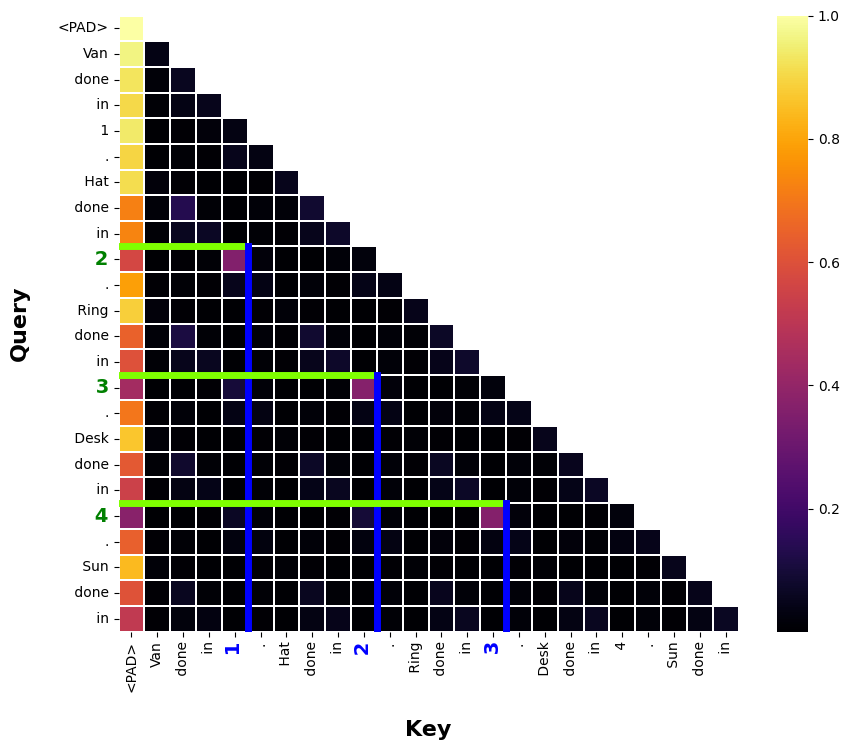

In [ ]:
layer = 2
head_ind = 4
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    highlightLines = 'early',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

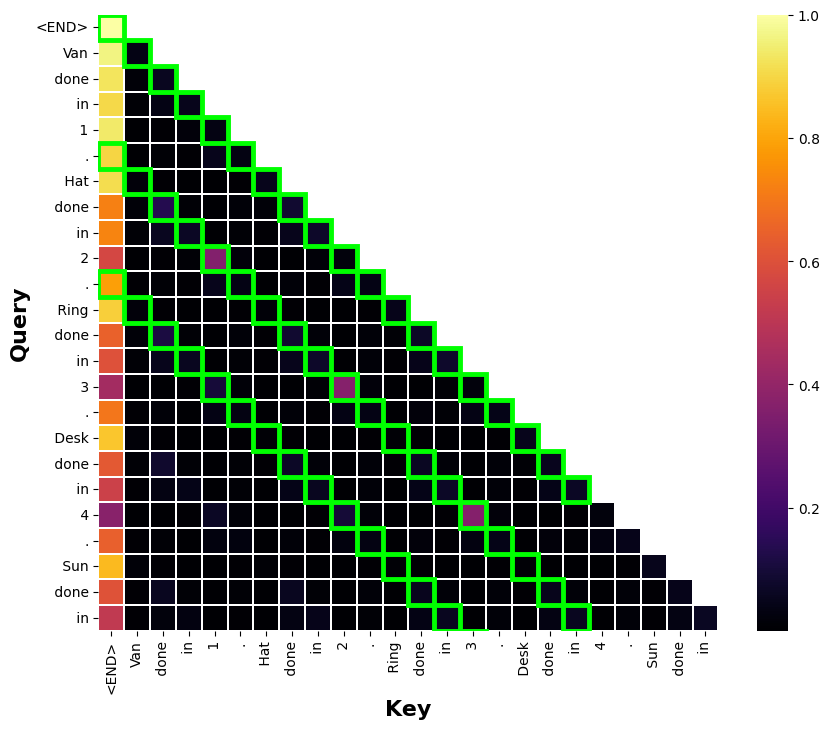

In [ ]:
viz_attnPat_dupl(layer = 2, head_index = 4)

#### L4H1:

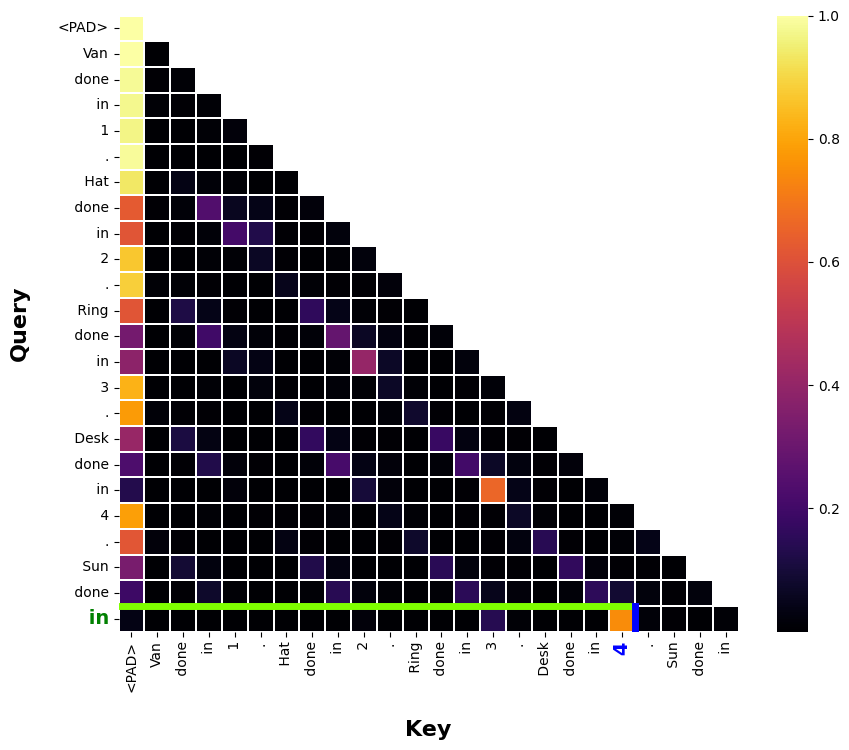

In [ ]:
layer = 4
head_ind = 1
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    highlightLines = 'late',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

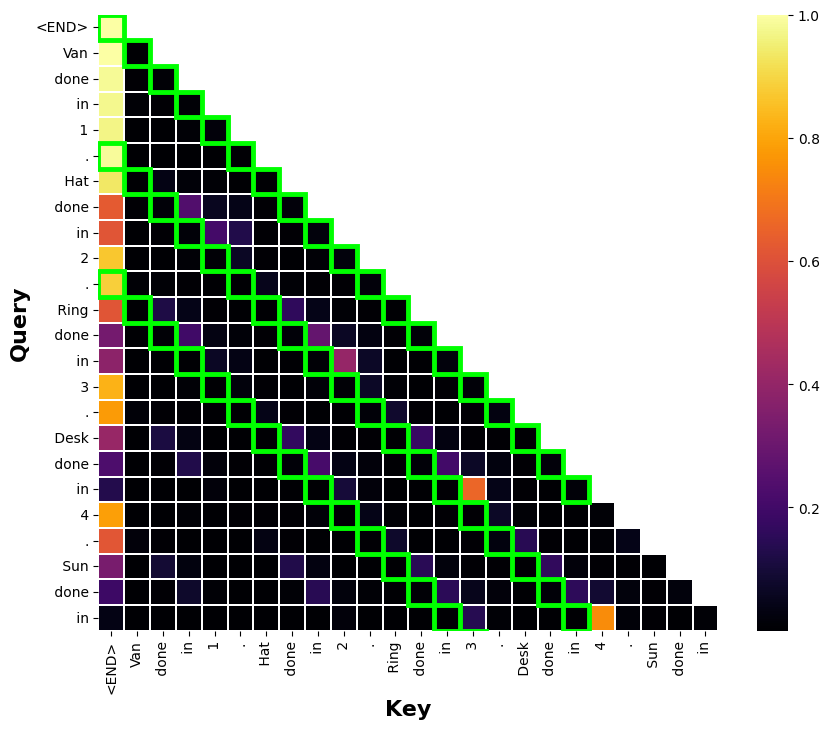

In [ ]:

viz_attnPat_dupl(layer = 4, head_index = 1)

#### L3H11:

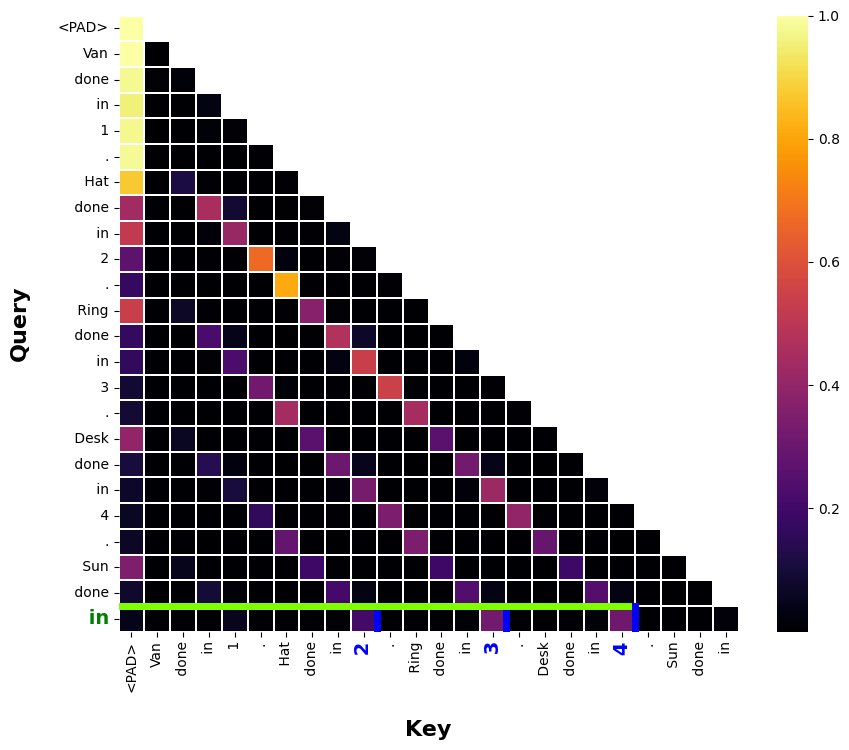

In [ ]:
layer = 3
head_ind = 11
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    highlightLines = 'mid',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

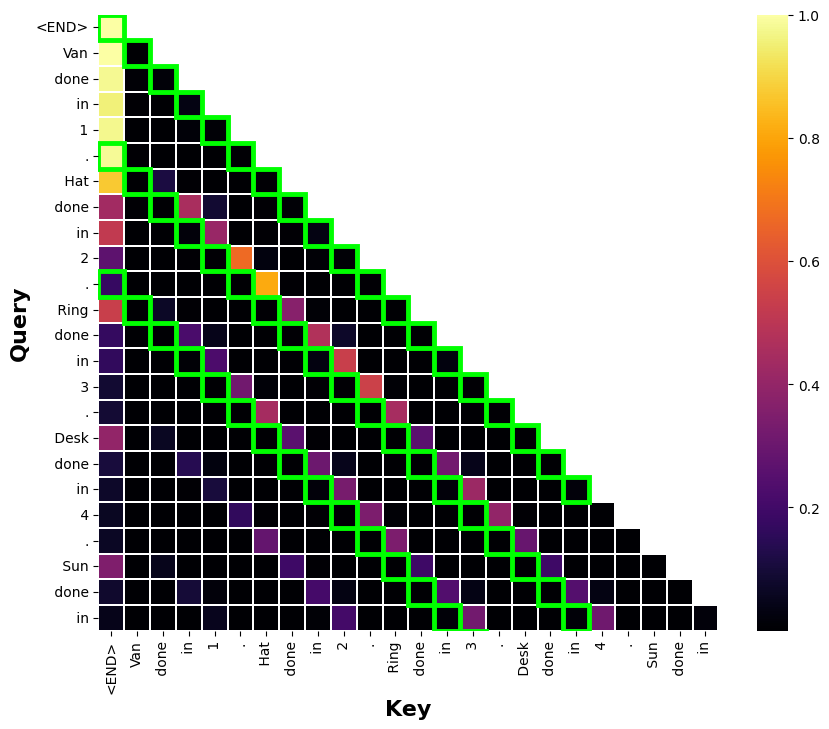

In [ ]:

viz_attnPat_dupl(layer = 3, head_index = 11)

#### L3H7:

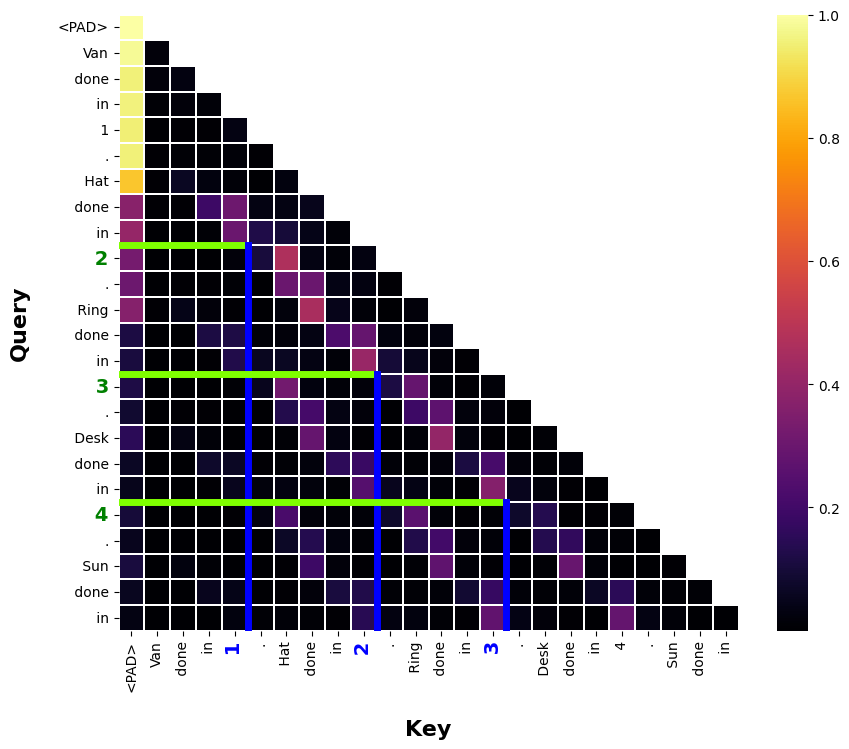

In [ ]:
layer = 3
head_ind = 7
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    highlightLines = 'early',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

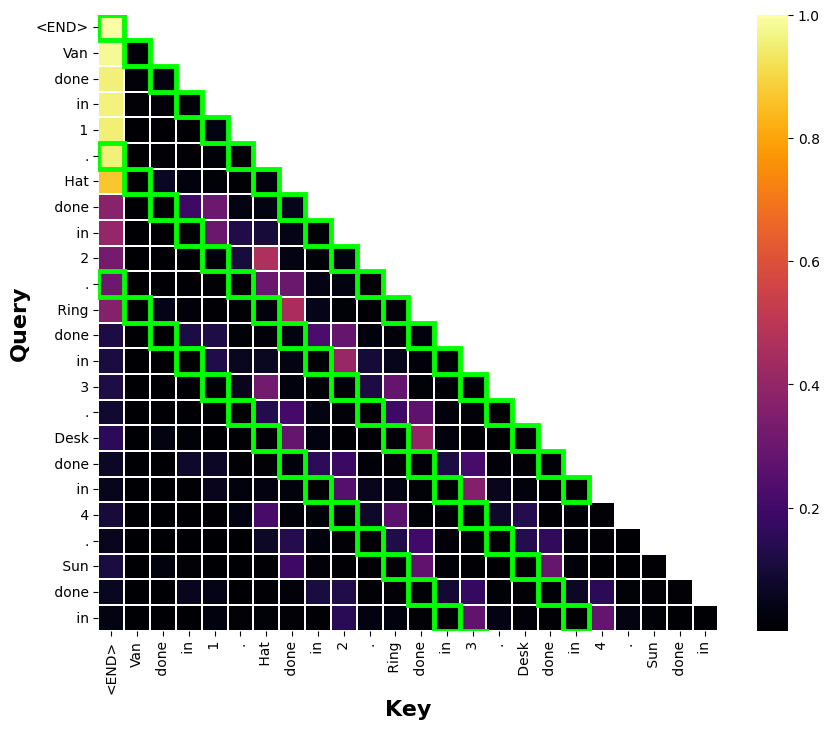

In [ ]:

viz_attnPat_dupl(layer = 3, head_index = 7)

#### L4H7:

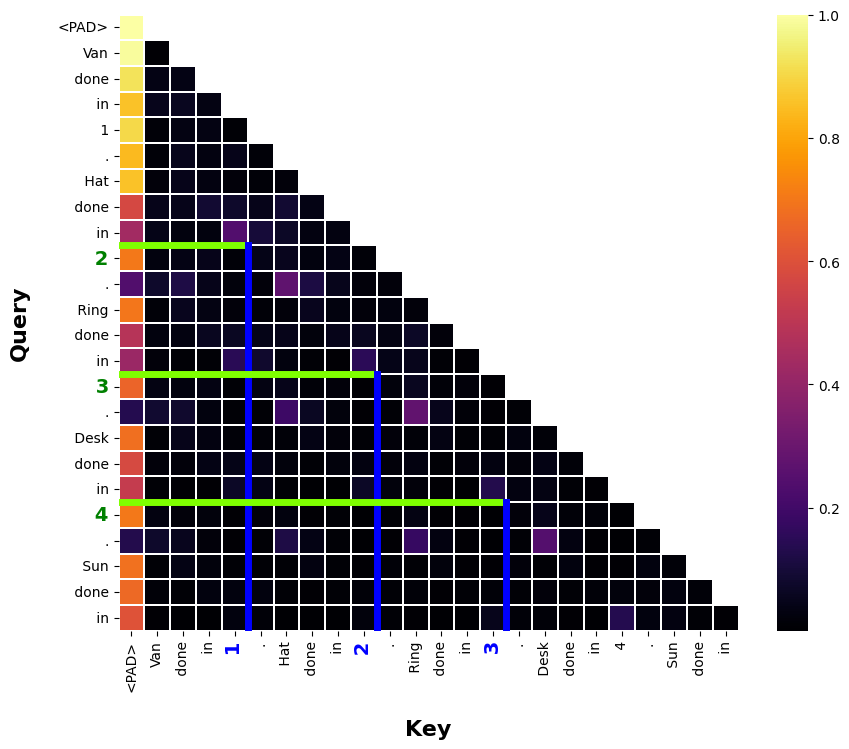

In [ ]:
layer = 4
head_ind = 7
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    highlightLines = 'early',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

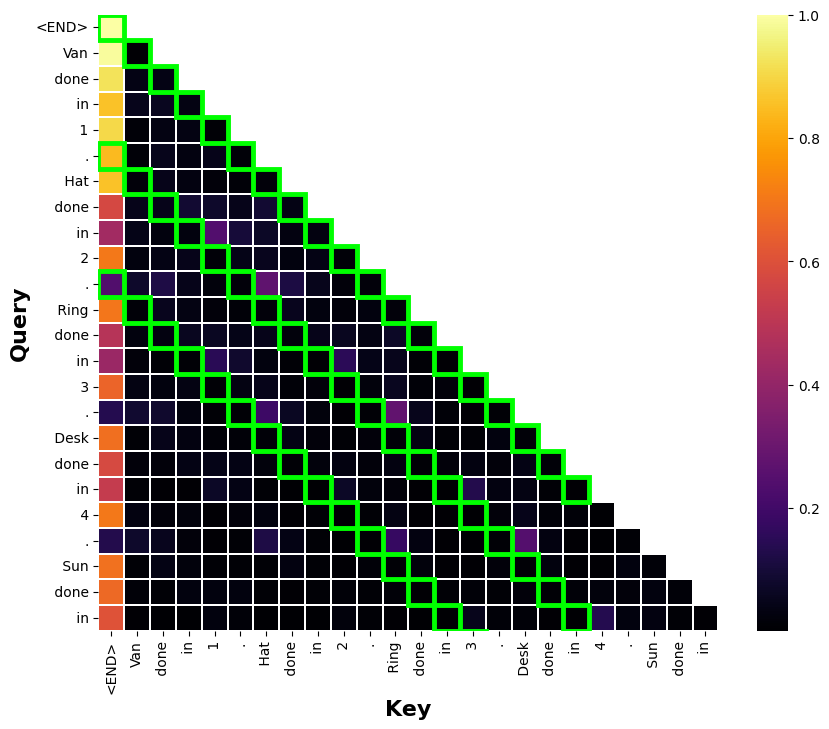

In [ ]:

viz_attnPat_dupl(layer = 4, head_index = 7)

#### L3H10:

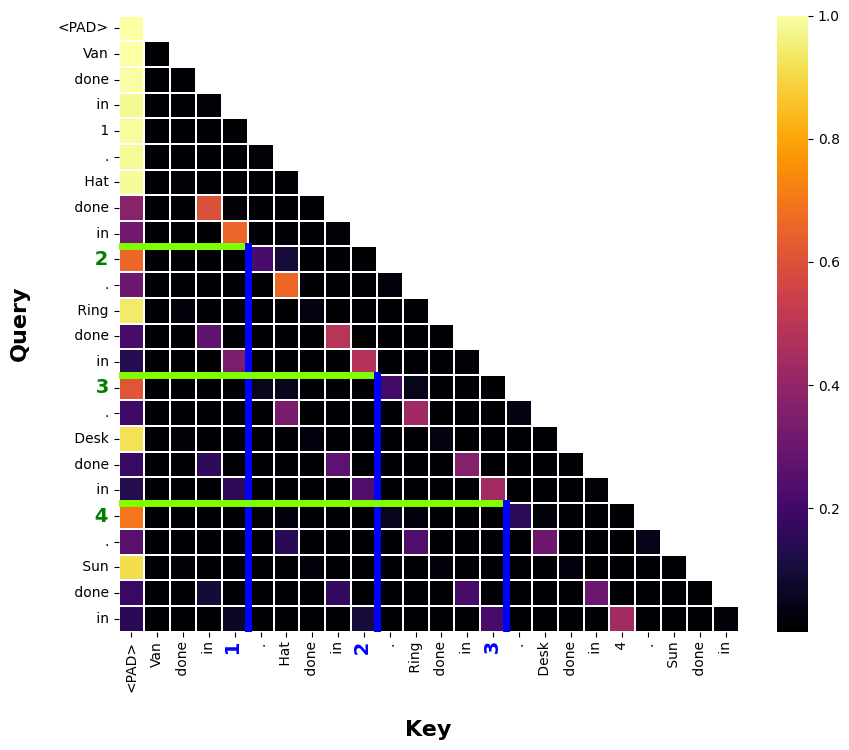

In [ ]:
layer = 3
head_ind = 10
viz_attn_pat(
    model,
    tokens,
    local_cache,
    layer,
    head_ind,
    highlightLines = 'early',
    savePlotName = f'attnpat{layer}_{head_ind}_{task}'
)

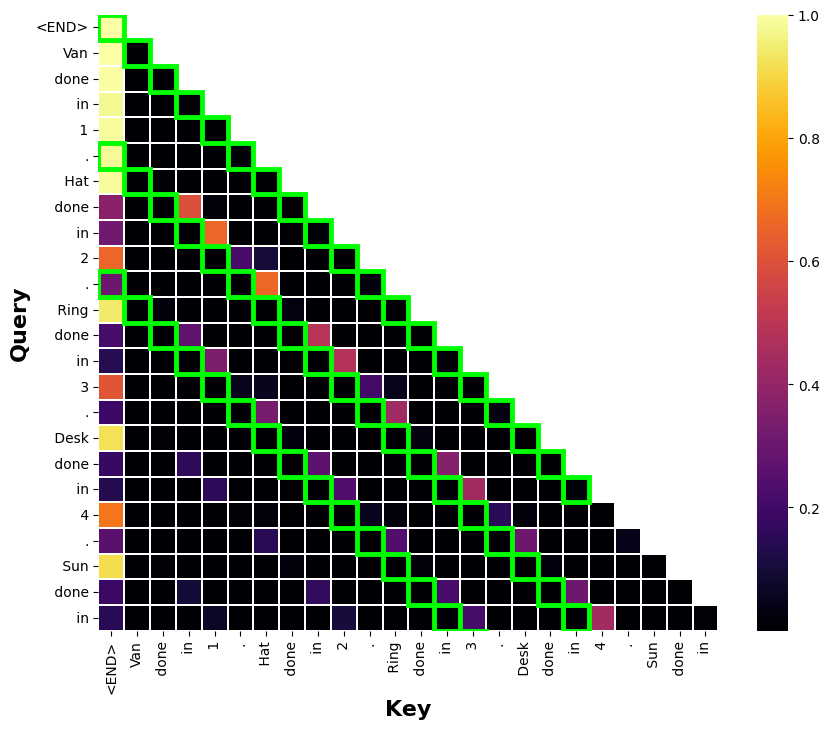

In [ ]:

viz_attnPat_dupl(layer = 3, head_index = 10)

In [ ]:
%cd ../../../../../../../../../../../../../../../../../../
!zip -r /content/seqcont_circ_expms.zip /content/seqcont_circuits
from google.colab import files
files.download("/content/seqcont_circ_expms.zip")
files.download("/content/seqcont_circuits")

/
  adding: content/seqcont_circuits/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/generate_data.ipynb (deflated 66%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/seqLen_corrToken_plot.ipynb (deflated 32%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/months_iterEdgePruning.ipynb (deflated 84%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/numerals_iterEdgePruning.ipynb (deflated 92%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/numwords_iterEdgePruning.ipynb (deflated 92%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/test prompts/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/test prompts/multiprompt_test_pt1.ipynb (deflated 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%cd ../../../../../../../../../../../../../../../../../../
!zip -r /content/seqcont_circ_expms_zip.zip /content/seqcont_circ_expms


# from google.colab import files
# files.download("/content/seqcont_circ_expms.zip")
# files.download("/content/seqcont_circuits")

/
  adding: content/seqcont_circ_expms/ (stored 0%)
  adding: content/seqcont_circ_expms/nbs_as_py/ (stored 0%)
  adding: content/seqcont_circ_expms/nbs_as_py/iter_edge_pruning/ (stored 0%)
  adding: content/seqcont_circ_expms/nbs_as_py/iter_edge_pruning/numwords_iteredgepruning.py (deflated 80%)
  adding: content/seqcont_circ_expms/nbs_as_py/iter_edge_pruning/numerals_iteredgepruning.py (deflated 77%)
  adding: content/seqcont_circ_expms/nbs_as_py/iter_edge_pruning/months_iteredgepruning.py (deflated 77%)
  adding: content/seqcont_circ_expms/nbs_as_py/attn_pats/ (stored 0%)
  adding: content/seqcont_circ_expms/nbs_as_py/attn_pats/randorderdigitsmonths_attnpat.py (deflated 63%)
  adding: content/seqcont_circ_expms/nbs_as_py/attn_pats/months_attnpats.py (deflated 64%)
  adding: content/seqcont_circ_expms/nbs_as_py/attn_pats/inorderdigitsmonths_attnpat.py (deflated 59%)
  adding: content/seqcont_circ_expms/nbs_as_py/attn_pats/numerals_attnpats.py (deflated 66%)
  adding: content/seqcont_

In [ ]:
!zip -r /content/seqcont_circuits_zip.zip /content/seqcont_circuits

  adding: content/seqcont_circuits/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/generate_data.ipynb (deflated 66%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/seqLen_corrToken_plot.ipynb (deflated 32%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/months_iterEdgePruning.ipynb (deflated 84%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/numerals_iterEdgePruning.ipynb (deflated 92%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/iter_edge_pruning/numwords_iterEdgePruning.ipynb (deflated 92%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/test prompts/ (stored 0%)
  adding: content/seqcont_circuits/notebooks/gpt2_expms/test prompts/multiprompt_test_pt1.ipynb (deflated 74